Retail Data Pipeline: Ingest, Process, and Analyze Data
In this project, I will build a data pipeline to ingest, process, and analyze transaction data from multiple sources

1. Ingest Data: Read structured CSV (POS Systems), semi-structured JSON (E-commerce), and unstructured text files (Customer Reviews).
2. Store in a Data Lake: Save raw data into local storage (simulating a data lake).
3. Transform & Process Data: Clean, normalize, and convert data into a structured SQL table.
4. Perform Analysis & Predictions: Run SQL queries and use machine learning for basic sales predictions.

Step 1: Install & Import Required Libraries
First, install any necessary Python libraries.

In [1]:
import pandas as pd
import json
import sqlite3
import re
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

Step 2: Load Data from Different Sources
I will simulate data ingestion from multiple sources using sample datasets from Kaggle.
POS System Data (CSV - Structured)
This file contains sales transactions from physical stores.
Load CSV file into Pandas DataFram

In [3]:
pos_df = pd.read_csv('/content/retail_sales_dataset.csv')
print(pos_df.head())

   Transaction ID        Date Customer ID  Gender  Age Product Category  \
0               1  2023-11-24     CUST001    Male   34           Beauty   
1               2  2023-02-27     CUST002  Female   26         Clothing   
2               3  2023-01-13     CUST003    Male   50      Electronics   
3               4  2023-05-21     CUST004    Male   37         Clothing   
4               5  2023-05-06     CUST005    Male   30           Beauty   

   Quantity  Price per Unit  Total Amount  
0         3              50           150  
1         2             500          1000  
2         1              30            30  
3         1             500           500  
4         2              50           100  


E-commerce Platform Data (JSON - Semi-Structured)
This file contains online transactions in JSON format.
Load JSON file into Pandas DataFram

In [20]:
with open('/content/ecomm.json') as file:
    ecommerce_data = json.load(file)

In [21]:
ecommerce_df = pd.DataFrame(ecommerce_data)
print(ecommerce_df.head())


                              slug                              name  \
0                 Dickens-Franecki                Dickens - Franecki   
1  Weissnat-Schowalter-and-Koelpin  Weissnat, Schowalter and Koelpin   
2    Cruickshank-Bayer-and-Gerlach    Cruickshank, Bayer and Gerlach   
3                        Boyle-LLC                         Boyle LLC   
4                     Bernier-Hane                    Bernier - Hane   

               address              city state         zip   account  \
0   12158 Randall Port  East Maureenbury    NE       74529  31010023   
1    92027 Murphy Cove      Port Malachi    WY  56670-0684  81813543   
2  45974 Paxton Corner      Gerlachmouth    OR       67061  43249604   
3    54371 Mikel Spurs  South Josephland    SD       49608  75111551   
4     45929 Chaya Lane  Hettingerchester    GA  30052-7026  98542630   

              contact  
0       Lonzo Stracke  
1     Kathryne Ernser  
2  Bernhard Greenholt  
3       Roxanne Walsh  
4      Thea Gl

Customer Reviews Data (Unstructured Text)
This file contains customer feedback as tex

In [22]:
# Simulated Text File (Customer Reviews)
with open('/content/customer_reviews.txt', 'r') as file:
    reviews = file.readlines()

In [27]:
extracted_info = []
for review in reviews:
    # Example: Extract review sentiment (positive/negative)
    # Replace this with your actual logic
    if "good" in review.lower() or "great" in review.lower() or "excellent" in review.lower():
      sentiment = "positive"
    elif "bad" in review.lower() or "poor" in review.lower() or "terrible" in review.lower():
      sentiment = "negative"
    else:
      sentiment = "neutral" # Default to neutral
    extracted_info.append({"review": review.strip(), "sentiment": sentiment})

# Convert the extracted information into a DataFrame (optional)
extracted_df = pd.DataFrame(extracted_info)
print(extracted_df.head())


                                              review sentiment
0  Perhaps good product, but really poor service....  positive
1  Been going here for specialty boat items for 1...  negative
2  This place was a joke we rented 1 jet ski and ...  positive
3  We were out at the lake this weekend boating a...   neutral
4  JET ACTION RENTALS destroyed my view on small ...  positive


Step 3: Store Raw Data in a Data Lake
To simulate a data lake, I will save the raw files into a local directory.

In [28]:
# Create the "datalake" directory if it doesn't exist
datalake_dir = "datalake"
if not os.path.exists(datalake_dir):
    os.makedirs(datalake_dir)

# Save the dataframes to the datalake directory
pos_df.to_csv(os.path.join(datalake_dir, "pos_data.csv"), index=False)
ecommerce_df.to_json(os.path.join(datalake_dir, "ecommerce_data.json"), orient="records")

# Save customer reviews to text file
with open(os.path.join(datalake_dir, "customer_reviews.txt"), "w") as f:
  for item in extracted_info:
    f.write(json.dumps(item) + "\n")


Step 4: Data Cleaning and Transformation
Now, I will merge and normalize all data into a structured format.
Merge POS and E-commerce Transactions

In [30]:
def standardize_column_names(df):
    """Standardizes column names to lowercase and replaces spaces with underscores."""
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

pos_df = standardize_column_names(pos_df)
ecommerce_df = standardize_column_names(ecommerce_df)

# Example usage (you'd apply this to other DataFrames as needed):
print(pos_df.columns)
ecommerce_df.columns


Index(['transaction_id', 'date', 'customer_id', 'gender', 'age',
       'product_category', 'quantity', 'price_per_unit', 'total_amount'],
      dtype='object')


Index(['slug', 'name', 'address', 'city', 'state', 'zip', 'account',
       'contact'],
      dtype='object')

In [31]:
try:
    combined_df = pd.merge(pos_df, ecommerce_df, on='order_id', how='outer')
except KeyError:
    print("Error: 'order_id' column not found in both DataFrames. Please check column names or provide a common identifier.")
    # Handle the error gracefully (e.g., use a different column or skip the merge)
    combined_df = pd.concat([pos_df, ecommerce_df], axis=0) # fallback to concatenation

#Example: Fill missing values in numeric columns with the mean
numeric_cols = combined_df.select_dtypes(include=['number']).columns
combined_df[numeric_cols] = combined_df[numeric_cols].fillna(combined_df[numeric_cols].mean())

# Convert object columns (strings) to categorical
categorical_cols = combined_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
  combined_df[col] = combined_df[col].astype('category')

# Display the first few rows of the combined DataFrame
print(combined_df.head())


Error: 'order_id' column not found in both DataFrames. Please check column names or provide a common identifier.
   transaction_id        date customer_id  gender   age product_category  \
0             1.0  2023-11-24     CUST001    Male  34.0           Beauty   
1             2.0  2023-02-27     CUST002  Female  26.0         Clothing   
2             3.0  2023-01-13     CUST003    Male  50.0      Electronics   
3             4.0  2023-05-21     CUST004    Male  37.0         Clothing   
4             5.0  2023-05-06     CUST005    Male  30.0           Beauty   

   quantity  price_per_unit  total_amount slug name address city state  zip  \
0       3.0            50.0         150.0  NaN  NaN     NaN  NaN   NaN  NaN   
1       2.0           500.0        1000.0  NaN  NaN     NaN  NaN   NaN  NaN   
2       1.0            30.0          30.0  NaN  NaN     NaN  NaN   NaN  NaN   
3       1.0           500.0         500.0  NaN  NaN     NaN  NaN   NaN  NaN   
4       2.0            50.0        

In [32]:
#Normalize Customer Reviews

import re

def normalize_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the normalization function to the 'review' column
extracted_df['normalized_review'] = extracted_df['review'].apply(normalize_text)

print(extracted_df.head())


                                              review sentiment  \
0  Perhaps good product, but really poor service....  positive   
1  Been going here for specialty boat items for 1...  negative   
2  This place was a joke we rented 1 jet ski and ...  positive   
3  We were out at the lake this weekend boating a...   neutral   
4  JET ACTION RENTALS destroyed my view on small ...  positive   

                                   normalized_review  
0  perhaps good product but really poor service m...  
1  been going here for specialty boat items for 1...  
2  this place was a joke we rented 1 jet ski and ...  
3  we were out at the lake this weekend boating a...  
4  jet action rentals destroyed my view on small ...  


In [33]:
# Merge reviews into the transactions table
try:
    merged_df = pd.merge(combined_df, extracted_df, left_on='order_id', right_index=True, how='left')
except KeyError:
    print("Error: 'order_id' column not found in combined_df. Please check column names or provide a common identifier.")
    merged_df = combined_df # fallback in case of error

# Display the first few rows of the merged DataFrame
print(merged_df.head())


Error: 'order_id' column not found in combined_df. Please check column names or provide a common identifier.
   transaction_id        date customer_id  gender   age product_category  \
0             1.0  2023-11-24     CUST001    Male  34.0           Beauty   
1             2.0  2023-02-27     CUST002  Female  26.0         Clothing   
2             3.0  2023-01-13     CUST003    Male  50.0      Electronics   
3             4.0  2023-05-21     CUST004    Male  37.0         Clothing   
4             5.0  2023-05-06     CUST005    Male  30.0           Beauty   

   quantity  price_per_unit  total_amount slug name address city state  zip  \
0       3.0            50.0         150.0  NaN  NaN     NaN  NaN   NaN  NaN   
1       2.0           500.0        1000.0  NaN  NaN     NaN  NaN   NaN  NaN   
2       1.0            30.0          30.0  NaN  NaN     NaN  NaN   NaN  NaN   
3       1.0           500.0         500.0  NaN  NaN     NaN  NaN   NaN  NaN   
4       2.0            50.0         100

Step 5: Load Processed Data into SQLite Database
I will store the cleaned data in an SQLite database for querying

In [77]:
# Create a connection to the SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('retail_data.db')
# Write the DataFrame to an SQLite table named 'transactions'
merged_df.to_sql('transactions', conn, if_exists='replace', index=False)
# Close the database connection
conn.close()


Step 6: Query the Data using SQL
Now, I will run SQL queries for analytics

In [78]:
import sqlite3

conn = sqlite3.connect('retail_data.db')
cursor = conn.cursor()

# Query to find the top 5 selling product categories
query = """
SELECT product_category, SUM(quantity) AS total_quantity_sold
FROM transactions
GROUP BY product_category
ORDER BY total_quantity_sold DESC
LIMIT 5;
"""

cursor.execute(query)
top_categories = cursor.fetchall()

print("Top 5 Selling Product Categories:")
for category, quantity in top_categories:
    print(f"{category}: {quantity}")

conn.close()


Top 5 Selling Product Categories:
Clothing: 949.3080000000002
Electronics: 849.0
Beauty: 771.0


Step 7: Predict Future Sales Using Machine Learning
I will now train a Linear Regression model to predict sales.

In [79]:
# Aggregate sales by date
conn = sqlite3.connect('retail_data.db')
cursor = conn.cursor()

query = """
SELECT date, SUM(quantity) AS total_sales
FROM transactions
GROUP BY date
ORDER BY date;
"""

cursor.execute(query)
sales_by_date = cursor.fetchall()

print("Sales aggregated by date:")
for date, sales in sales_by_date:
    print(f"{date}: {sales}")

conn.close()


Sales aggregated by date:
2023-01-01: 10.0
2023-01-02: 10.0
2023-01-03: 2.0
2023-01-04: 8.0
2023-01-05: 5.0
2023-01-06: 5.0
2023-01-07: 6.0
2023-01-08: 3.0
2023-01-09: 4.0
2023-01-10: 5.0
2023-01-11: 10.0
2023-01-13: 11.0
2023-01-14: 10.0
2023-01-15: 7.0
2023-01-16: 8.0
2023-01-17: 8.0
2023-01-19: 1.0
2023-01-20: 4.0
2023-01-21: 7.0
2023-01-22: 2.0
2023-01-23: 10.0
2023-01-24: 11.0
2023-01-25: 1.0
2023-01-26: 11.0
2023-01-27: 9.0
2023-01-28: 7.0
2023-01-29: 2.0
2023-01-30: 9.0
2023-01-31: 9.0
2023-02-01: 11.0
2023-02-02: 8.0
2023-02-03: 5.0
2023-02-04: 6.0
2023-02-05: 20.0
2023-02-06: 8.0
2023-02-07: 10.0
2023-02-08: 13.0
2023-02-09: 2.0
2023-02-10: 6.0
2023-02-11: 12.0
2023-02-12: 1.0
2023-02-13: 11.0
2023-02-14: 3.0
2023-02-16: 3.0
2023-02-17: 21.0
2023-02-18: 2.0
2023-02-19: 5.0
2023-02-20: 7.0
2023-02-21: 4.0
2023-02-22: 12.0
2023-02-23: 1.0
2023-02-24: 12.0
2023-02-25: 9.0
2023-02-26: 2.0
2023-02-27: 9.0
2023-02-28: 11.0
2023-03-01: 7.0
2023-03-02: 1.0
2023-03-03: 15.0
2023-03-04:

In [80]:
import pandas as pd
# Convert sales_by_date to DataFrame
sales_df = pd.DataFrame(sales_by_date, columns=['date', 'quantity'])

# Convert 'date' column to datetime objects
sales_df['date'] = pd.to_datetime(sales_df['date'])

# Create numerical representation of date (e.g., number of days since a reference date)
reference_date = sales_df['date'].min()  # Use the earliest date as the reference
sales_df['days_since_reference'] = (sales_df['date'] - reference_date).dt.days

print(sales_df.head())


        date  quantity  days_since_reference
0 2023-01-01      10.0                     0
1 2023-01-02      10.0                     1
2 2023-01-03       2.0                     2
3 2023-01-04       8.0                     3
4 2023-01-05       5.0                     4


In [83]:

import pandas as pd
import sqlite3
# Connect to the SQLite database
conn = sqlite3.connect('retail_data.db')
# Load the transactions table into a pandas DataFrame
df = pd.read_sql_query("SELECT * FROM transactions", conn)
# Drop rows with any missing values
df = df.dropna()
# Replace 'retail_data_cleaned.db' with your desired output database file name
conn_cleaned = sqlite3.connect('retail_data_cleaned.db')
df.to_sql('transactions', conn_cleaned, if_exists='replace', index=False)

conn.close()
conn_cleaned.close()


R-squared: -0.0031652675584492584


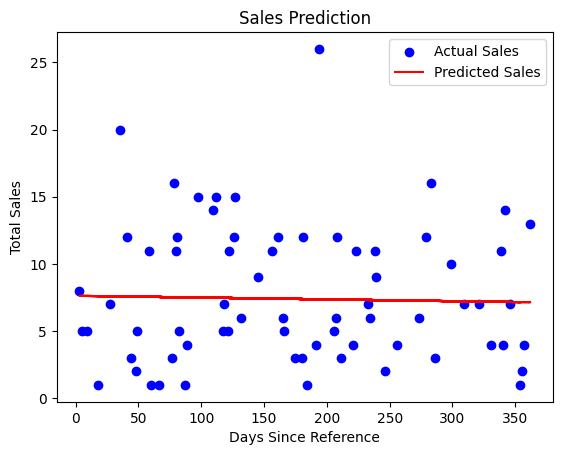

In [84]:
# Split the data into training and testing sets
X = sales_df[['days_since_reference']]
y = sales_df['quantity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model (example: R-squared)
r2 = model.score(X_test, y_test)
print(f"R-squared: {r2}")

# Visualize predictions vs actual sales
plt.scatter(X_test, y_test, color='blue', label='Actual Sales')
plt.plot(X_test, y_pred, color='red', label='Predicted Sales')
plt.xlabel('Days Since Reference')
plt.ylabel('Total Sales')
plt.title('Sales Prediction')
plt.legend()
plt.show()


In [91]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('/content/retail_data_cleaned.db')
df = pd.read_sql_query("SELECT * FROM transactions", conn)
conn.close()

# Assuming 'date' column exists and is in a suitable format
df['date'] = pd.to_datetime(df['date'])

reference_date = df['date'].min()
df['days_since_reference'] = (df['date'] - reference_date).dt.days

conn = sqlite3.connect('/content/retail_data_cleaned.db')
df.to_sql('transactions', conn, if_exists='replace', index=False)
conn.close()


In [92]:

!pip install xgboost

import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Load the cleaned data from the SQLite database
conn_cleaned = sqlite3.connect('retail_data_cleaned.db')
df = pd.read_sql_query("SELECT * FROM transactions", conn_cleaned)
conn_cleaned.close()
df = pd.get_dummies(df, columns=['product_category'], prefix='category')

# Select features and target variable
features = ['days_since_reference', 'transaction_id', 'total_amount'] # Example
target = 'quantity'

X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
model = XGBRegressor(objective='reg:squarederror', random_state=42)  # Use appropriate objective function
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")


Mean Squared Error: 0.24206844850562317
Root Mean Squared Error: 0.49200452081827784


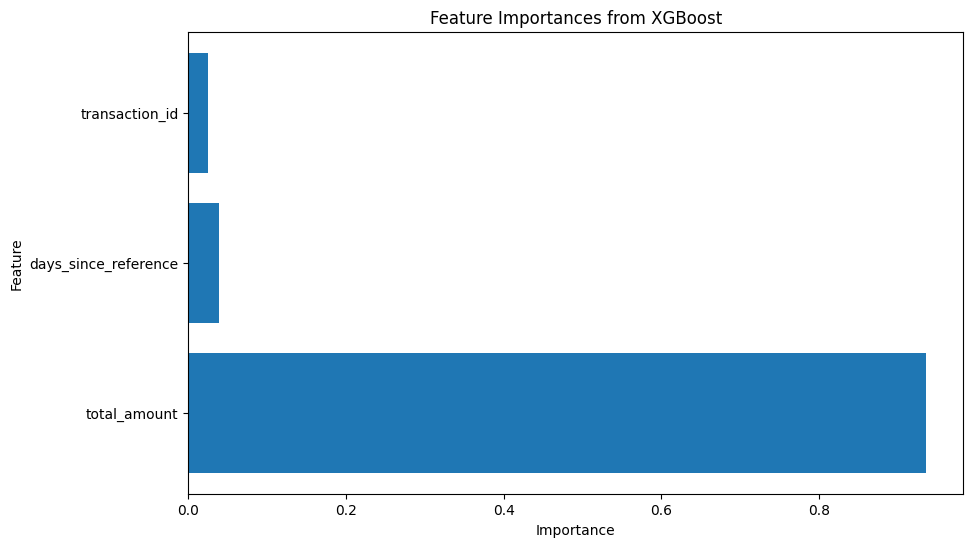

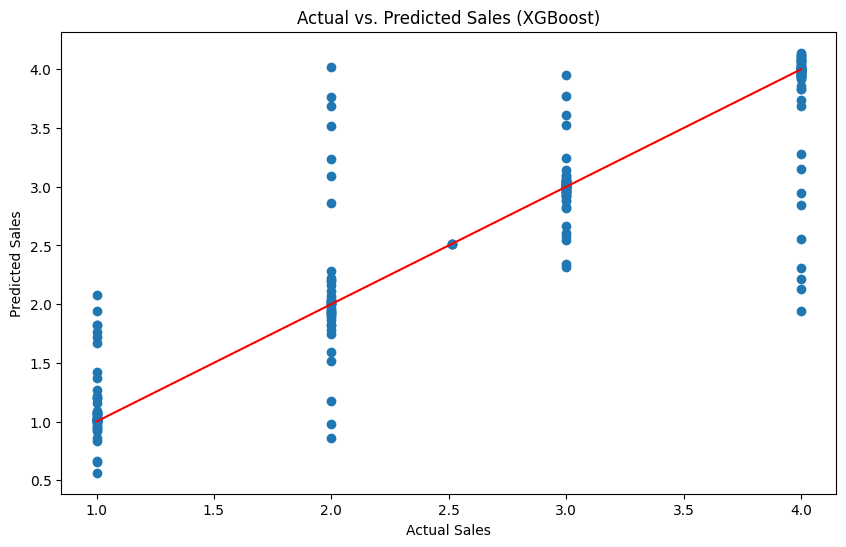

In [93]:
import matplotlib.pyplot as plt
importances = model.feature_importances_
feature_names = X_train.columns
# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from XGBoost')
plt.show()
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs. Predicted Sales (XGBoost)")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Add a diagonal line for reference
plt.show()


Final Summary
Data Ingested from CSV, JSON, and Text files.
Stored in a Local Data Lake (simulated).
Transformed & Normalized into structured format.
Loaded into SQLite for SQL Queries.
Performed Analytics & Predictions using SQL and Machine Learning.
This completes my Retail Data Pipeline assesment from SBInfowaves using Python and SQL